In [55]:
import pandas as pandas
pandas.set_option('display.max_columns', None)
import numpy as numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve

In [56]:
#Read in dataset and create dataframe
application_training_df= pandas.read_csv('application_train.csv')
application_testing_df=pandas.read_csv('application_test.csv')
application_training_df.head()

application_training_df.shape

(307511, 122)

In [57]:
# Identify numerical and categorical features
numerical_features = application_training_df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = application_training_df.select_dtypes(include=['object']).columns

# Fill missing values for numerical features using simple imputer
numerical_imputer = SimpleImputer(strategy='median') 
application_training_df[numerical_features] = numerical_imputer.fit_transform(application_training_df[numerical_features])

# Fill missing values for categorical features using simple imputer
categorical_imputer = SimpleImputer(strategy='most_frequent')  
application_training_df[categorical_features] = categorical_imputer.fit_transform(application_training_df[categorical_features])


In [58]:
# Identify numerical and categorical features
numerical_features = application_testing_df.select_dtypes(include=['float64', 'int64']).columns
categorical_features = application_testing_df.select_dtypes(include=['object']).columns

# Fill missing values for numerical features using simple imputer
numerical_imputer = SimpleImputer(strategy='median') 
application_testing_df[numerical_features] = numerical_imputer.fit_transform(application_testing_df[numerical_features])

# Fill missing values for categorical features using simple imputer
categorical_imputer = SimpleImputer(strategy='most_frequent')  
application_testing_df[categorical_features] = categorical_imputer.fit_transform(application_testing_df[categorical_features])


In [59]:
OHC=OneHotEncoder(handle_unknown='ignore')

#get categorcial features
categorical_features = application_training_df.select_dtypes(include=['object']).columns

# Fit and transform using one hot encoder
encoded_features = OHC.fit_transform(application_training_df[categorical_features]).toarray()

df_encoded = pandas.DataFrame(encoded_features, columns=OHC.get_feature_names_out(categorical_features), index=application_training_df.index)

train_application_df= application_training_df.merge(df_encoded, left_index=True, right_index=True)

# Drop all of orignial categorical features as they will not be needed
train_application_df.drop(categorical_features, axis=1, inplace=True)

train_application_df.shape

(307511, 246)

In [60]:
OHC=OneHotEncoder(handle_unknown='ignore')

#get categorcial features
categorical_features = application_testing_df.select_dtypes(include=['object']).columns

# Fit and transform using one hot encoder
encoded_features = OHC.fit_transform(application_testing_df[categorical_features]).toarray()

df_encoded = pandas.DataFrame(encoded_features, columns=OHC.get_feature_names_out(categorical_features), index=application_testing_df.index)

test_application_df= application_testing_df.merge(df_encoded, left_index=True, right_index=True)

# Drop all of orignial categorical features as they will not be needed
test_application_df.drop(categorical_features, axis=1, inplace=True)

test_application_df.shape

(48744, 242)

In [61]:
train_application_df=train_application_df.drop(columns=['CODE_GENDER_XNA', 'NAME_FAMILY_STATUS_Unknown', 'NAME_INCOME_TYPE_Maternity leave'])

In [62]:


X= train_application_df.drop(columns=['TARGET'])
y=train_application_df['TARGET']

X_test= test_application_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Instantiate SelectKBest with ANOVA F-value as scoring function
selector = SelectKBest(score_func=f_classif, k=25)

# Fit and transform X_train and X_test
X_train_25= selector.fit_transform(X_train, y_train)
X_test_25= selector.transform(X_test)



In [63]:
scaler=MinMaxScaler()
scaler.fit(X_train)

X_train=scaler.transform(X_train)

X_train=pandas.DataFrame(X_train)

scaler=MinMaxScaler()
scaler.fit(X_test)

X_test=scaler.transform(X_test)

X_test=pandas.DataFrame(X_test)


scaler=MinMaxScaler()
scaler.fit(X_train_25)

X_train_25=scaler.transform(X_train_25)

X_train_25=pandas.DataFrame(X_train_25)

scaler=MinMaxScaler()
scaler.fit(X_test_25)

X_test_25=scaler.transform(X_test_25)

X_test_25=pandas.DataFrame(X_test_25)

In [64]:
lognet = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(242,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [65]:
# Calculate class weights
import numpy as np
total_samples = len(y_train)
class_counts = np.bincount(y_train)
weight_for_0 = total_samples / (2 * class_counts[0])  # weight for class 0 (non-default)
weight_for_1 = total_samples / (2 * class_counts[1])  # weight for class 1 (default)

class_weights = {0: weight_for_0, 1: weight_for_1}
lognet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = lognet.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

lognet.summary()

y_preds=lognet.predict(X_test)
y_pred = (y_preds > 0.5).astype(int)
accuracy= accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision :", precision)
print("Recall: ", recall)
print("F1 Score:", f1)

Epoch 1/10
6151/6151 [==============================] - 22s 3ms/step - loss: 0.6315 - accuracy: 0.6480 - val_loss: 0.6347 - val_accuracy: 0.6439
Epoch 2/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.6148 - accuracy: 0.6705 - val_loss: 0.7338 - val_accuracy: 0.5781
Epoch 3/10
6151/6151 [==============================] - 21s 3ms/step - loss: 0.6104 - accuracy: 0.6668 - val_loss: 0.5903 - val_accuracy: 0.7033
Epoch 4/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.6079 - accuracy: 0.6708 - val_loss: 0.5849 - val_accuracy: 0.7020
Epoch 5/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.6070 - accuracy: 0.6728 - val_loss: 0.5399 - val_accuracy: 0.7354
Epoch 6/10
6151/6151 [==============================] - 18s 3ms/step - loss: 0.6063 - accuracy: 0.6762 - val_loss: 0.6225 - val_accuracy: 0.6554
Epoch 7/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.6040 - accuracy: 0.6712 - val_loss: 0.5956 - val_ac

In [66]:
print(class_weights)

{0: 0.543947782710983, 1: 6.188569128597304}


1922/1922 [==============================] - 2s 1ms/step


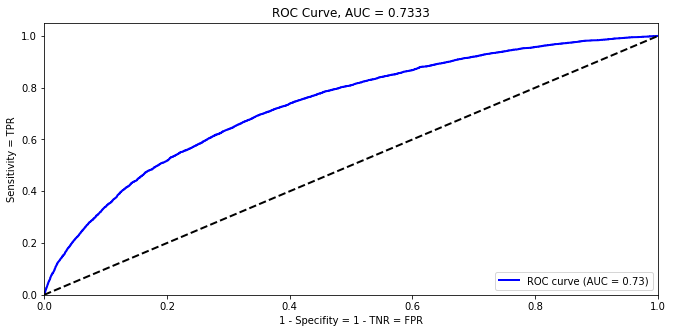

In [67]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities from the neural network model
y_pred_proba = lognet.predict(X_test)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(11, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('1 - Specifity = 1 - TNR = FPR')
plt.ylabel('Sensitivity = TPR')
plt.title('ROC Curve, AUC = ' + str(round(roc_auc,4)))
plt.legend(loc="lower right")
plt.show()

1922/1922 [==============================] - 3s 2ms/step


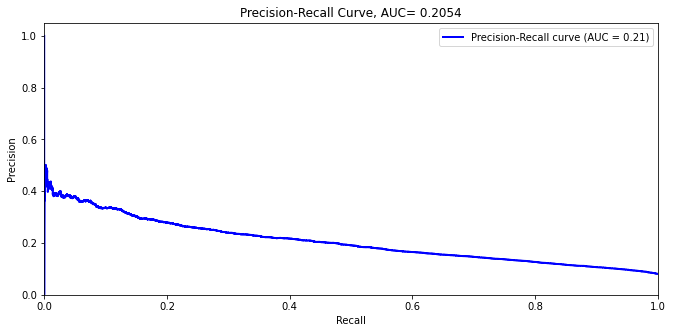

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

# Get predicted probabilities from the neural network model
y_pred_proba = lognet.predict(X_test)

# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(11, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve, AUC= ' + str(round(pr_auc,4)))
plt.legend(loc="upper right")
plt.show()


In [69]:
lognet = tf.keras.Sequential([
   tf.keras.layers.Dense(128, activation='relu', input_shape=(242,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [70]:
lognet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = lognet.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

lognet.summary()

y_preds=lognet.predict(X_test)
y_pred = (y_preds > 0.5).astype(int)
accuracy= accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision :", precision)
print("Recall: ", recall)
print("F1 Score:", f1)

Epoch 1/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.2646 - accuracy: 0.9192 - val_loss: 0.2551 - val_accuracy: 0.9193
Epoch 2/10
6151/6151 [==============================] - 23s 4ms/step - loss: 0.2582 - accuracy: 0.9191 - val_loss: 0.2526 - val_accuracy: 0.9193
Epoch 3/10
6151/6151 [==============================] - 19s 3ms/step - loss: 0.2561 - accuracy: 0.9192 - val_loss: 0.2519 - val_accuracy: 0.9192
Epoch 4/10
6151/6151 [==============================] - 22s 4ms/step - loss: 0.2553 - accuracy: 0.9192 - val_loss: 0.2517 - val_accuracy: 0.9193
Epoch 5/10
6151/6151 [==============================] - 23s 4ms/step - loss: 0.2547 - accuracy: 0.9191 - val_loss: 0.2520 - val_accuracy: 0.9193
Epoch 6/10
6151/6151 [==============================] - 22s 4ms/step - loss: 0.2542 - accuracy: 0.9192 - val_loss: 0.2520 - val_accuracy: 0.9193
Epoch 7/10
6151/6151 [==============================] - 22s 4ms/step - loss: 0.2539 - accuracy: 0.9191 - val_loss: 0.2524 - val_ac

c:\Users\14804\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1922/1922 [==============================] - 3s 1ms/step


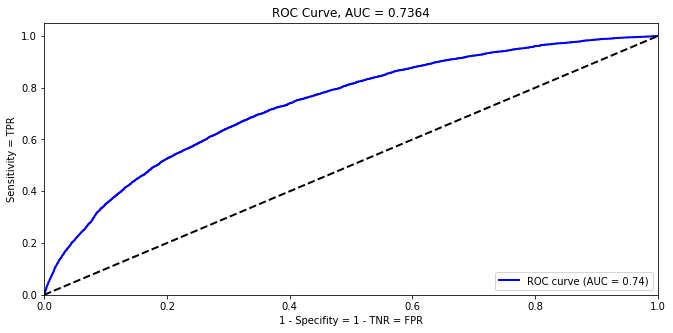

In [71]:
# Get predicted probabilities from the neural network model
y_pred_proba = lognet.predict(X_test)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(11, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('1 - Specifity = 1 - TNR = FPR')
plt.ylabel('Sensitivity = TPR')
plt.title('ROC Curve, AUC = ' + str(round(roc_auc,4)))
plt.legend(loc="lower right")
plt.show()

1922/1922 [==============================] - 3s 2ms/step


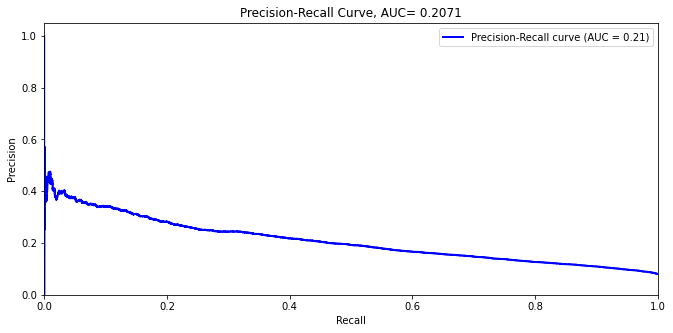

In [72]:
# Get predicted probabilities from the neural network model
y_pred_proba = lognet.predict(X_test)

# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(11, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve, AUC= ' + str(round(pr_auc,4)))
plt.legend(loc="upper right")
plt.show()


In [73]:
lognet = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(25,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [74]:
lognet.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = lognet.fit(X_train_25, y_train, epochs=10, batch_size=32, validation_split=0.2, class_weight=class_weights)

lognet.summary()

y_preds=lognet.predict(X_test_25)
y_pred = (y_preds > 0.5).astype(int)
accuracy= accuracy_score(y_test, y_pred)
precision=precision_score(y_test, y_pred)
recall=recall_score(y_test, y_pred)
f1=f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision :", precision)
print("Recall: ", recall)
print("F1 Score:", f1)

Epoch 1/10
6151/6151 [==============================] - 21s 3ms/step - loss: 0.6232 - accuracy: 0.6607 - val_loss: 0.6679 - val_accuracy: 0.6166
Epoch 2/10
6151/6151 [==============================] - 19s 3ms/step - loss: 0.6135 - accuracy: 0.6658 - val_loss: 0.5961 - val_accuracy: 0.6997
Epoch 3/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.6107 - accuracy: 0.6684 - val_loss: 0.5192 - val_accuracy: 0.7773
Epoch 4/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.6101 - accuracy: 0.6685 - val_loss: 0.5928 - val_accuracy: 0.6790
Epoch 5/10
6151/6151 [==============================] - 19s 3ms/step - loss: 0.6094 - accuracy: 0.6639 - val_loss: 0.6252 - val_accuracy: 0.6527
Epoch 6/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.6094 - accuracy: 0.6616 - val_loss: 0.6295 - val_accuracy: 0.6377
Epoch 7/10
6151/6151 [==============================] - 20s 3ms/step - loss: 0.6084 - accuracy: 0.6658 - val_loss: 0.5985 - val_ac

   1/1922 [..............................] - ETA: 43s

1922/1922 [==============================] - 3s 2ms/step


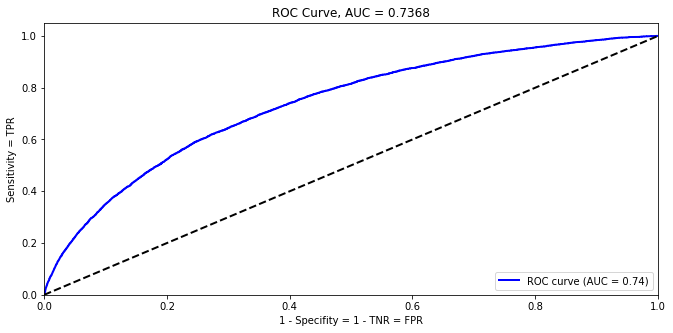

In [75]:
# Get predicted probabilities from the neural network model
y_pred_proba = lognet.predict(X_test_25)

# Calculate false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(11, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle= '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('1 - Specifity = 1 - TNR = FPR')
plt.ylabel('Sensitivity = TPR')
plt.title('ROC Curve, AUC = ' + str(round(roc_auc,4)))
plt.legend(loc="lower right")
plt.show()

1922/1922 [==============================] - 4s 2ms/step


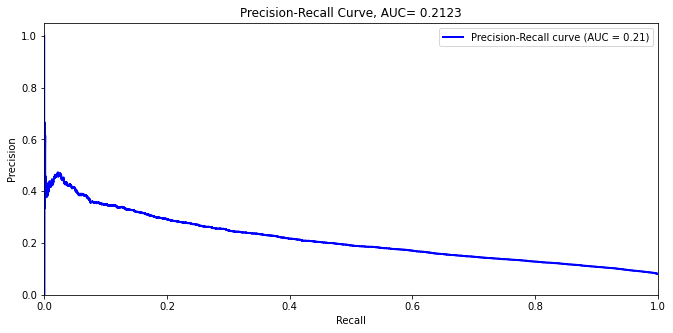

In [77]:
# Get predicted probabilities from the neural network model
y_pred_proba = lognet.predict(X_test_25)

# Calculate precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Calculate area under the precision-recall curve (AUC)
pr_auc = auc(recall, precision)

# Plot ROC curve
plt.figure(figsize=(11, 5))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve, AUC= ' + str(round(pr_auc,4)))
plt.legend(loc="upper right")
plt.show()
